# Marlon Tzorin - 20180072

In [41]:
# Librerias

import numpy as np
import pandas as pd


import PIL
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib

from os import listdir,path
from os.path import isfile, join
import random
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Activation 
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [3]:

# paths de los datos
path_n= 'placas/Train/Algeria/'
path_t= 'placas/Train/Brazil/'
path_h= 'placas/Train/Guatemala/'


#conjunto de paths
paths=[path_n,
path_t,
path_h]

# Pic tiene grupos de paths (Algeria,Brazil,Guatemala)
pics=[]
diag=[]
images=[]
nombres=[]

#listdir me enlista cada path de imagen que esta dentro de mis paths
for i in paths:
    onlyfiles=([f for f in listdir(i)])
    pics.append(onlyfiles)
# pics solo son los paths de cada una de las imagenes   
    
    
for x,i in enumerate(paths): # enumero cada uno de los paths y le digo que para cada uno me abra el minifolder con libreria PIL
    for j in pics[x]:
        im = Image.open(i+"/"+j) 
        images.append(im.copy())
        im.close # cada imagen que abro la tegno que cerrar
        diag.append(x) # esto es para los grupos , 0 = Algeria , 1 = Brazil , 2= Guatemala


In [8]:
images_sinaug=[] # todas las imagenes que cargue

for i in images:
    images_sinaug.append(np.array(i.resize((120,80)))) # las guardo como array para que los pueda procesar mi red neuronal y les pongo a todas el mismo shape de 120,80
images_sinaug_array=np.array(images_sinaug) # array
diag_aug=np.array(diag) # convierto np.array porque solo es la predicion de saber de que pais es la placa

In [9]:
images_resize_est=images_sinaug_array/255 # esto lo hago para que corra mas rapido la red estos son los valores de RGB 

In [19]:
def summarize_diagnostics(histories):
    """
    """
    fig,axs = plt.subplots(2,1,figsize=(20,10))
    ax1=axs[0]
    ax2=axs[1]
    for i in range(len(histories)):
        
        ax1.set_title('Cross Entropy Loss',fontsize=16)
        ax1.plot(histories[i].history['loss'], color='r', ls='--',label='train')
        ax1.plot(histories[i].history['val_loss'], color='orange', label='test')
        ax1.grid(alpha=0.3)
        # plot accuracy
        ax2.set_title('Classification Accuracy',fontsize=16)
        ax2.plot(histories[i].history['accuracy'], color='green',ls='--', label='train')
        ax2.plot(histories[i].history['val_accuracy'], color='lightgreen', label='test')
        ax2.grid(alpha=0.3)
        
    plt.show()


def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()

# Primer Modelo

In [11]:
cnn_model = keras.Sequential()

cnn_model.add(layers.Conv2D(16, (3, 3), padding = 'same', input_shape=(80, 120, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(16, (5, 5)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.25))


cnn_model.add(Flatten())

cnn_model.add(Dense(8, activation='relu'))
cnn_model.add(layers.Dropout(0.15))

cnn_model.add(Dense(3, activation = 'sigmoid'))

In [12]:
cnn_model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
                    loss = 'sparse_categorical_crossentropy',
                    metrics = ['accuracy'],
                 )

In [13]:
x_train, x_test, y_train, y_test = train_test_split(images_resize_est, diag_aug, test_size = 0.2, random_state=14)

In [14]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 120, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 60, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 56, 16)        6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 28, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 28, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8064)              0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6

In [15]:
model_checkpoint = ModelCheckpoint("./model/", save_best_only=True, verbose=1, monitor='val_accuracy', mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=1, mode='auto')

In [21]:
history = cnn_model.fit(x = x_train,
                                y = y_train,
                                batch_size = 15, 
                                epochs = 100,
                                validation_split=0.1,
                                shuffle=True,
                                callbacks=[model_checkpoint, reduce_lr]
                                 )

Epoch 1/100
8/8 [==============================] - 1s 80ms/step - loss: 0.2977 - accuracy: 0.8919 - val_loss: 0.3071 - val_accuracy: 0.8462

Epoch 00001: val_accuracy did not improve from 0.84615
Epoch 2/100
8/8 [==============================] - 1s 76ms/step - loss: 0.2430 - accuracy: 0.9459 - val_loss: 0.3071 - val_accuracy: 0.8462

Epoch 00002: val_accuracy did not improve from 0.84615
Epoch 3/100
8/8 [==============================] - 1s 77ms/step - loss: 0.2571 - accuracy: 0.9099 - val_loss: 0.3071 - val_accuracy: 0.8462

Epoch 00003: val_accuracy did not improve from 0.84615
Epoch 4/100
8/8 [==============================] - 1s 80ms/step - loss: 0.2701 - accuracy: 0.8919 - val_loss: 0.3071 - val_accuracy: 0.8462

Epoch 00004: val_accuracy did not improve from 0.84615

Epoch 00004: ReduceLROnPlateau reducing learning rate to 8.589935979235544e-27.
Epoch 5/100
8/8 [==============================] - 1s 76ms/step - loss: 0.2592 - accuracy: 0.8829 - val_loss: 0.3071 - val_accuracy: 0.

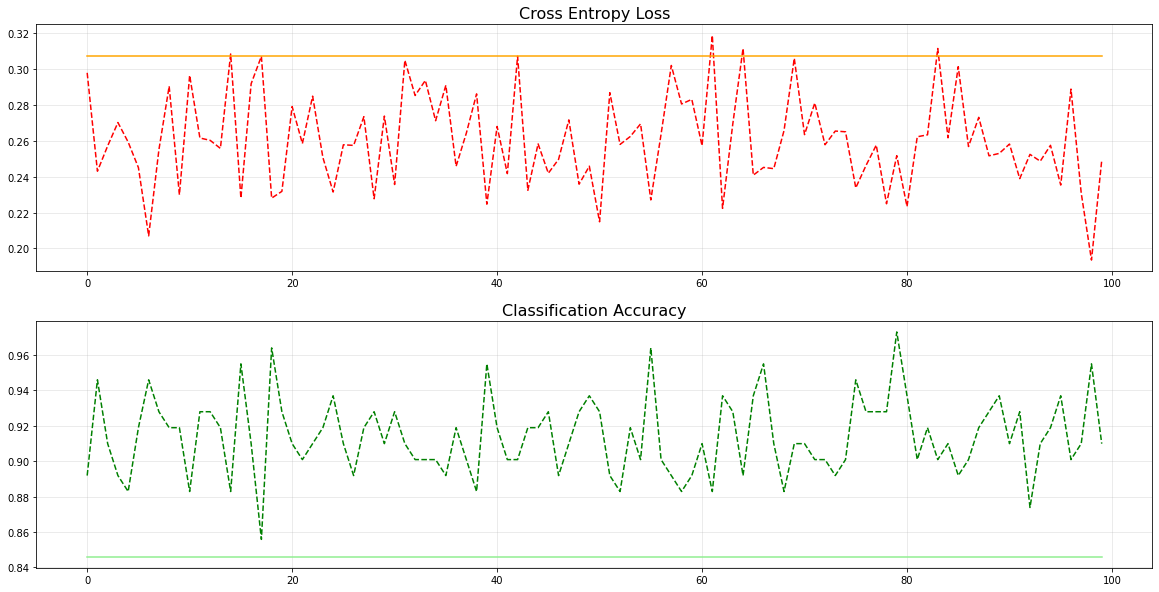

In [22]:
summarize_diagnostics([history])

# Segundo Modelo

In [23]:
cnn_model = keras.Sequential()

cnn_model.add(layers.Conv2D(16, (3, 3), padding = 'same', input_shape=(80, 120, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(8, (5, 5)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.25))


cnn_model.add(Flatten())

cnn_model.add(Dense(4, activation='relu'))
cnn_model.add(layers.Dropout(0.15))

cnn_model.add(Dense(3, activation = 'sigmoid'))

In [24]:
cnn_model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
                    loss = 'sparse_categorical_crossentropy',
                    metrics = ['accuracy'],
                 )

In [25]:
x_train, x_test, y_train, y_test = train_test_split(images_resize_est, diag_aug, test_size = 0.2, random_state=14)
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 80, 120, 16)       448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 40, 60, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 56, 8)         3208      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 28, 8)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 18, 28, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4032)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                

In [26]:
model_checkpoint = ModelCheckpoint("./model/", save_best_only=True, verbose=1, monitor='val_accuracy', mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=1, mode='auto')

In [27]:
history2 = cnn_model.fit(x = x_train,
                                y = y_train,
                                batch_size = 15, 
                                epochs = 100,
                                validation_split=0.1,
                                shuffle=True,
                                callbacks=[model_checkpoint, reduce_lr]
                                 )

Epoch 1/100
8/8 [==============================] - 1s 91ms/step - loss: 1.0931 - accuracy: 0.3874 - val_loss: 1.0373 - val_accuracy: 0.5385

Epoch 00001: val_accuracy improved from -inf to 0.53846, saving model to ./model\
INFO:tensorflow:Assets written to: ./model\assets
Epoch 2/100
8/8 [==============================] - 1s 90ms/step - loss: 1.0382 - accuracy: 0.4595 - val_loss: 0.9581 - val_accuracy: 0.5385

Epoch 00002: val_accuracy did not improve from 0.53846
Epoch 3/100
8/8 [==============================] - 1s 78ms/step - loss: 1.0111 - accuracy: 0.5225 - val_loss: 0.9184 - val_accuracy: 0.4615

Epoch 00003: val_accuracy did not improve from 0.53846
Epoch 4/100
8/8 [==============================] - 1s 69ms/step - loss: 0.9853 - accuracy: 0.5135 - val_loss: 0.9202 - val_accuracy: 0.5385

Epoch 00004: val_accuracy did not improve from 0.53846

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 5/100
8/8 [==============================] - 1s 73m

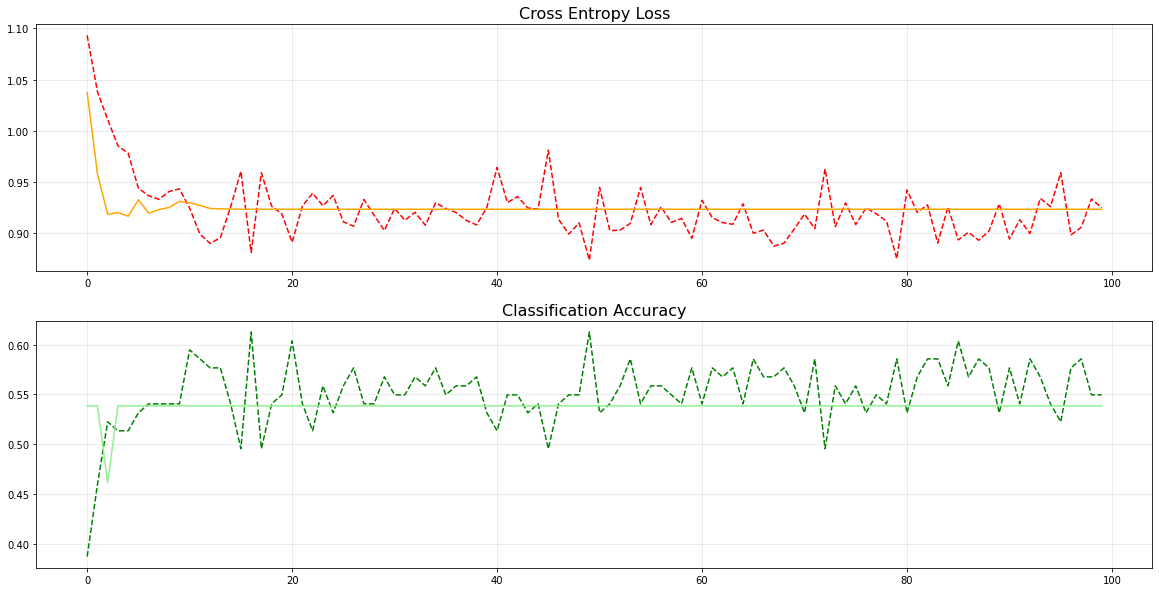

In [28]:
summarize_diagnostics([history2])

# Tercer Modelo

In [29]:
cnn_model = keras.Sequential()

cnn_model.add(layers.Conv2D(16, (3, 3), padding = 'same', input_shape=(80, 120, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(8, (5, 5)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.25))


cnn_model.add(Flatten())

cnn_model.add(Dense(4, activation='relu'))
cnn_model.add(layers.Dropout(0.25))

cnn_model.add(Dense(3, activation = 'softmax'))

In [30]:
cnn_model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
                    loss = 'sparse_categorical_crossentropy',
                    metrics = ['accuracy'],
                 )

In [31]:
x_train, x_test, y_train, y_test = train_test_split(images_resize_est, diag_aug, test_size = 0.2, random_state=14)
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 80, 120, 16)       448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 40, 60, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 36, 56, 8)         3208      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 28, 8)         0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 18, 28, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4032)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                

In [32]:
model_checkpoint = ModelCheckpoint("./model/", save_best_only=True, verbose=1, monitor='val_accuracy', mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=1, mode='auto')

In [33]:
history3 = cnn_model.fit(x = x_train,
                                y = y_train,
                                batch_size = 25, 
                                epochs = 100,
                                validation_split=0.1,
                                shuffle=True,
                                callbacks=[model_checkpoint, reduce_lr]
                                 )

Epoch 1/100
5/5 [==============================] - 1s 125ms/step - loss: 1.0773 - accuracy: 0.3784 - val_loss: 1.0262 - val_accuracy: 0.3846

Epoch 00001: val_accuracy improved from -inf to 0.38462, saving model to ./model\
INFO:tensorflow:Assets written to: ./model\assets
Epoch 2/100
5/5 [==============================] - 0s 100ms/step - loss: 0.9801 - accuracy: 0.5315 - val_loss: 0.9101 - val_accuracy: 0.8462

Epoch 00002: val_accuracy improved from 0.38462 to 0.84615, saving model to ./model\
INFO:tensorflow:Assets written to: ./model\assets
Epoch 3/100
5/5 [==============================] - 1s 98ms/step - loss: 0.9411 - accuracy: 0.5946 - val_loss: 0.8616 - val_accuracy: 0.9231

Epoch 00003: val_accuracy improved from 0.84615 to 0.92308, saving model to ./model\
INFO:tensorflow:Assets written to: ./model\assets
Epoch 4/100
5/5 [==============================] - 0s 97ms/step - loss: 0.8912 - accuracy: 0.7297 - val_loss: 0.8023 - val_accuracy: 0.6923

Epoch 00004: val_accuracy did no

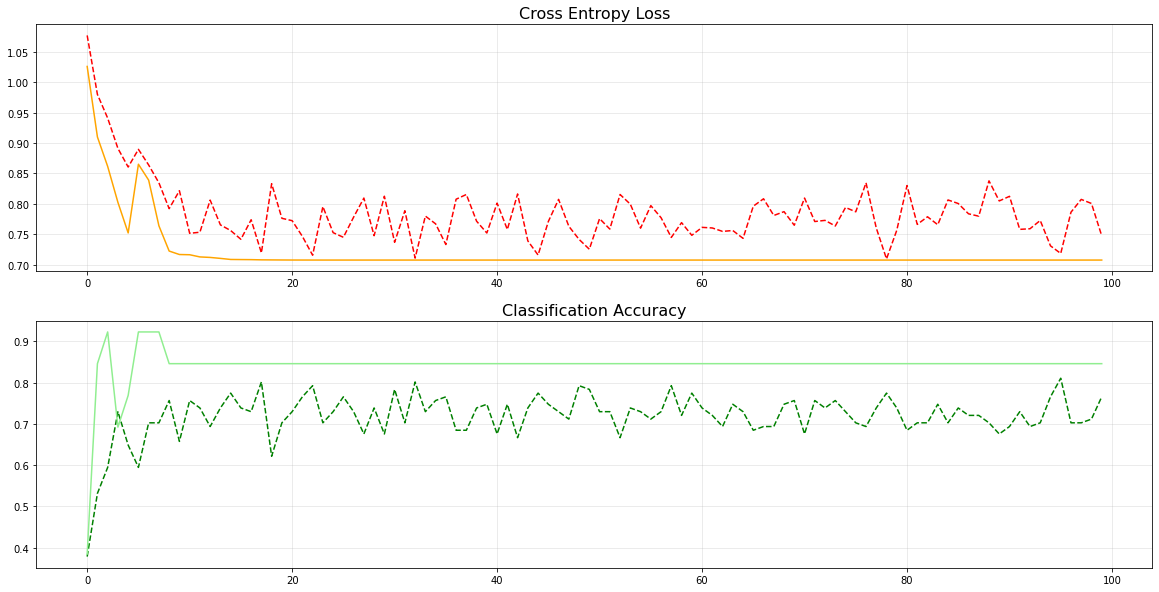

In [34]:
summarize_diagnostics([history3])

# Cuarto Modelo

In [35]:
cnn_model = keras.Sequential()

cnn_model.add(layers.Conv2D(16, (3, 3), padding = 'same', input_shape=(80, 120, 3)))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(10, (5, 5)))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(Dropout(0.25))


cnn_model.add(Flatten())

cnn_model.add(Dense(8, activation='relu'))
cnn_model.add(layers.Dropout(0.25))

cnn_model.add(Dense(3, activation = 'sigmoid'))

In [36]:
cnn_model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
                    loss = 'sparse_categorical_crossentropy',
                    metrics = ['accuracy'],
                 )

In [37]:
x_train, x_test, y_train, y_test = train_test_split(images_resize_est, diag_aug, test_size = 0.2, random_state=14)
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 80, 120, 16)       448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 40, 60, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 36, 56, 10)        4010      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 28, 10)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 18, 28, 10)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 5040)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                

In [38]:
model_checkpoint = ModelCheckpoint("./model/", save_best_only=True, verbose=1, monitor='val_accuracy', mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, verbose=1, mode='auto')

In [39]:
history4 = cnn_model.fit(x = x_train,
                                y = y_train,
                                batch_size = 15, 
                                epochs = 100,
                                validation_split=0.1,
                                shuffle=True,
                                callbacks=[model_checkpoint, reduce_lr]
                                 )

Epoch 1/100
8/8 [==============================] - 1s 85ms/step - loss: 1.0345 - accuracy: 0.4234 - val_loss: 0.7072 - val_accuracy: 0.6154

Epoch 00001: val_accuracy improved from -inf to 0.61538, saving model to ./model\
INFO:tensorflow:Assets written to: ./model\assets
Epoch 2/100
8/8 [==============================] - 1s 66ms/step - loss: 0.7606 - accuracy: 0.6486 - val_loss: 0.5574 - val_accuracy: 0.8462

Epoch 00002: val_accuracy improved from 0.61538 to 0.84615, saving model to ./model\
INFO:tensorflow:Assets written to: ./model\assets
Epoch 3/100
8/8 [==============================] - 1s 73ms/step - loss: 0.7651 - accuracy: 0.6396 - val_loss: 0.7718 - val_accuracy: 0.8462

Epoch 00003: val_accuracy did not improve from 0.84615
Epoch 4/100
8/8 [==============================] - 1s 75ms/step - loss: 0.5998 - accuracy: 0.8018 - val_loss: 0.4188 - val_accuracy: 0.9231

Epoch 00004: val_accuracy improved from 0.84615 to 0.92308, saving model to ./model\
INFO:tensorflow:Assets writte

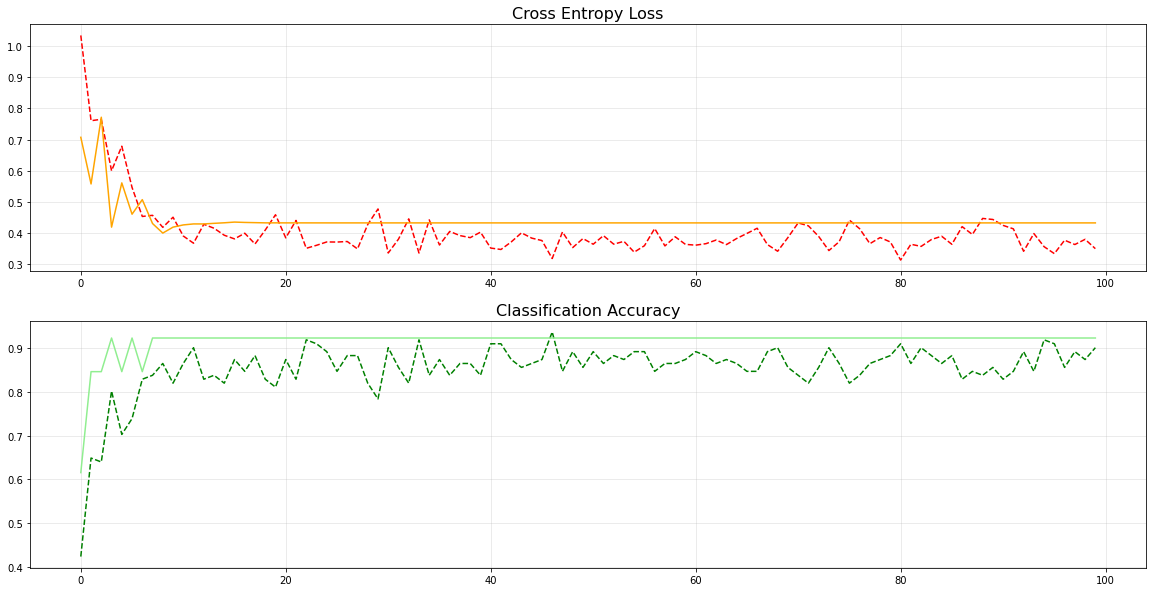

In [40]:
summarize_diagnostics([history4])